# Bird Specious Classification 

In [27]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from IPython.display import display_html
import itertools
import keras_preprocessing.image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
# The following resolves the issue of possibly truncated images in the datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
# List all data folders for the raw images
data_folders = [f for f in os.scandir('data') if f.is_dir()]
nspecies = len(data_folders)

train_ratio = 0.8

train_paths = []
train_labels = []
train_species = []

test_paths = []
test_labels = []
test_species = []

# Create dataframes that can be used directly by Keras ImageDataGenerator class
for i in range(nspecies):
    image_list = glob(data_folders[i].path + "/*.jpg")

    # Remove datasets with fewer than 50 images
    if len(image_list)<50:
        continue

    # Splitting the datasets to training and testing
    train_idx = math.floor(len(image_list)*train_ratio)
    for j in range(train_idx):
        train_paths.append(image_list[j][5:])
        train_labels.append(data_folders[i].name[:data_folders[i].name.find('_')])
        train_species.append(data_folders[i].name)
    for j in range(train_idx,len(image_list)):
        test_paths.append(image_list[j][5:])
        test_labels.append(data_folders[i].name[:data_folders[i].name.find('_')])
        test_species.append(data_folders[i].name)
train_set = pd.DataFrame({'paths':train_paths, 'family':train_labels, 'species':train_species})
test_set = pd.DataFrame({'paths':test_paths, 'family':test_labels, 'species':test_species})
print(len(train_set))
print(len(test_set))

#from collections import Counter
#Selected_samples = [w for w, _ in Counter(train_set['family']).most_common()]
#print(Selected_samples[:10])


16055
4043


In [29]:
# Patch the dataframe filenames interaction in Keras preprocessing
def patched_list_filenames(directory, white_list_formats, split,
                                       class_indices, follow_links, df=False):
    dirname = os.path.basename(directory)
    if split:
        num_files = len(list(
            _iter_valid_files(directory, white_list_formats, follow_links)))
        start, stop = int(split[0] * num_files), int(split[1] * num_files)
        valid_files = list(
            _iter_valid_files(
                directory, white_list_formats, follow_links))[start: stop]
    else:
        valid_files = _iter_valid_files(
            directory, white_list_formats, follow_links)
    if df:
        filenames = []
        for root, fname in valid_files:
            absolute_path = os.path.join(root, fname)
            relative_path = os.path.relpath(absolute_path, directory)
            filenames.append(relative_path)
        return filenames
    classes = []
    filenames = []
    for root, fname in valid_files:
        classes.append(class_indices[dirname])
        absolute_path = os.path.join(root, fname)
        relative_path = os.path.join(
            dirname, os.path.relpath(absolute_path, directory))
        filenames.append(relative_path)
    return classes, filenames

keras_preprocessing.image._list_valid_filenames_in_directory.__code__ = patched_list_filenames.__code__

# Some hyperparameters
image_size = 224
batch_size = 32



In [30]:
###########
#define function to generate images
from keras import backend as K
def imgGen(img, zca=False, rotation=0., w_shift=0., h_shift=0., shear=0., zoom=0., h_flip=False, v_flip=False,  preprocess_fcn=None, batch_size=9):
    train_generator = ImageDataGenerator(
        zca_whitening=zca,
        rotation_range=rotation,
        width_shift_range=w_shift,
        height_shift_range=h_shift,
        shear_range=shear,
        zoom_range=zoom,
        fill_mode='nearest',
        horizontal_flip=h_flip,
        vertical_flip=v_flip,
        preprocessing_function=preprocess_fcn,
        data_format=K.image_data_format())
    
    train_generator.fit(img)

    i=0
    for img_batch in train_generator.flow(img, batch_size=9, shuffle=False):
        for img in img_batch:
            plt.subplot(330 + 1 + i)
            plt.imshow(img)
            i=i+1    
        if i >= batch_size:
            break
    plt.show()


In [31]:
# Adaptive histogram equalization
def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

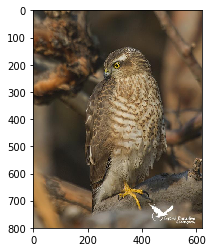

(1, 800, 621, 3)


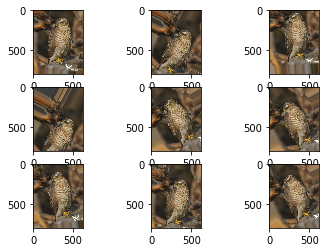

In [32]:
#### Visualize the generated image
Im = imread("sample1.jpg")
plt.imshow(Im)
plt.show()

# reshape it to prepare for data generator
Img = Im.astype('float32')
Img /= 255
h_dim = np.shape(Img)[0]
w_dim = np.shape(Img)[1]
num_channel = np.shape(Img)[2]
Img = Img.reshape(1, h_dim, w_dim, num_channel)
print(Img.shape)

# generate images using function imgGen
imgGen(Img, rotation=30, h_shift=0.3)

In [65]:
##########define function to generate more images
# Train set generation and augmentation using Keras preprocessing
#augmentation=True
train_generator = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest',
#             preprocessing_function = contrast_adjusment,
#             preprocessing_function = HE,
            preprocessing_function = AHE)
                                   
train_generator = train_generator.flow_from_dataframe(
    dataframe=train_set, 
    #dataframe= Selected_samples,
    directory='./data',
    x_col='paths', 
    y_col='family', 
    has_ext=True,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

# Test set generation using Keras preprocessing
test_generator = ImageDataGenerator()
test_generator = test_generator.flow_from_dataframe(
    dataframe=test_set, 
    directory="./data/", 
    x_col="paths", 
    y_col="family", 
    has_ext=True,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

num_classes = len(train_generator.class_indices)

Found 16055 images belonging to 59 classes.
Found 4043 images belonging to 59 classes.


In [66]:
#### visualization
# First we list the amount of training and testing images for each family
train_distribution = train_set.groupby('family', as_index=False).count().drop('species', axis=1)
train_distribution.columns=['family', '# Train Images']
test_distribution = test_set.groupby('family', as_index=False).count().drop('species', axis=1)
test_distribution.columns=['family', '# Test Images']
train_distribution = train_distribution.sort_values('# Train Images')
test_distribution = test_distribution.reindex(train_distribution.index)

family_species = train_set.groupby(['family', 'species'], as_index=False).count().drop('paths', axis=1)
family_species = family_species.groupby('family', as_index=False).count()

# Display side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
# display_side_by_side(train_distribution, test_distribution, family_species)

family_info = pd.merge(pd.merge(train_distribution,test_distribution),family_species)
display(family_info)

,family,# Train Images,# Test Images,species
0,leptocoma,41,11,1
1,motacilla,44,11,1
2,larvivora,45,12,1
3,centropus,45,12,1
4,caprimulgus,45,12,1
5,rhipidura,48,12,1
6,ninox,52,14,1
7,aviceda,53,14,1
8,treron,53,14,1
9,prinia,59,15,1


In [ ]:
# Read in all images belonging to a family
def read_images(family):
    paths = train_set['paths'][train_set['family']==family].tolist()
    paths = ['./data/' + s for s in paths]
    imgs = [load_img(img_path, target_size=(image_size, image_size)) for img_path in paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return img_array/255.

# Visualize images from a family
families = dict((v,k) for k,v in train_generator.class_indices.items())

family = families[0]

imgs = read_images(family)
n_imgs = imgs.shape[0]
columns = 4
fig = plt.figure(figsize=(20,int(n_imgs/columns*5)))
for i in range(n_imgs):
    plt.subplot(n_imgs/columns+1, columns, i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.suptitle(family.upper(), fontsize='x-large')
fig.tight_layout
fig.subplots_adjust(top=0.97)

In [ ]:
# Pretrained ResNet50 on ImageNet
''''
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False
''''

In [ ]:
# Pretrained VGG16 on ImageNet

model = Sequential()

model.add(VGG16(include_top=False, pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False

In [ ]:
def top_3_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[top_3_accuracy])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(len(train_generator))
print(len(train_set))
hist = model.fit_generator(generator=train_generator,
                           steps_per_epoch=int(train_set.shape[0]/batch_size)+1,
                           epochs=2,
                           shuffle=True,
                           validation_data=test_generator,
                           validation_steps=int(test_set.shape[0]/batch_size)+1)


In [ ]:
##########
plt.plot(hist.epoch,hist.hist['val_acc'],'-o',label='validation')
plt.plot(hist.epoch,hist.hist['acc'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

In [ ]:
######### evaluating
def read_test_images(family):
    paths = test_set['paths'][test_set['family']==family].tolist()
    paths = ['./data/' + s for s in paths]
    imgs = [load_img(img_path, target_size=(image_size, image_size)) for img_path in paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

prediction_results = []
ground_truth = []
test_distribution.to_dict()
for i in range(len(families)):
    prediction_results.append(model.predict_classes(read_test_images(families[i])))
    n_test_imgs = test_distribution.loc[test_distribution['family']==families[i]].iloc[0][1]
    ground_truth.append(np.ones(n_test_imgs)*i)
prediction_results = np.hstack(prediction_results)
ground_truth = np.hstack(ground_truth)

In [ ]:
print('Confusion Matrix')
CM = confusion_matrix(ground_truth, prediction_results)
print(CM)
target_names = [families[i] for i in range(len(families))]
print('Classification Report')
CR = classification_report(ground_truth, prediction_results, target_names=target_names)
print(CR)

In [ ]:
further_processed = family_info[family_info['species']>1]

A = dict(zip(further_processed.family.tolist(), further_processed.species.tolist()))
for key, value in A.items():
    family_to_classify = train_set[train_set.family==key]

In [ ]:
### classification using triplet loss
class sample_gen(object):
    def __init__(self, file_class_mapping):
        self.file_class_mapping= file_class_mapping
        self.class_to_list_files = defaultdict(list)
        self.list_all_files = list(file_class_mapping.keys())
        self.range_all_files = list(range(len(self.list_all_files)))

        for file, class_ in file_class_mapping.items():
            self.class_to_list_files[class_].append(file)

        self.list_classes = list(set(self.file_class_mapping.values()))
        self.range_list_classes= range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight/np.sum(self.class_weight)

    def get_sample(self):
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        positive_example_1, positive_example_2 = self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]], self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]

        negative_example = None
        while negative_example is None or self.file_class_mapping[negative_example] == self.file_class_mapping[positive_example_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_example = self.list_all_files[negative_example_idx]
        return positive_example_1, negative_example, positive_example_2

    
def read_img(img_path):
    img = load_img('./data/' + img_path, target_size=(image_size, image_size))
    img_array = np.array(img_to_array(img))
    return preprocess_input(img_array)


def gen(triplet_gen):
    while True:
        list_positive_examples_1 = []
        list_negative_examples = []
        list_positive_examples_2 = []

        for i in range(batch_size):
            path_pos1, path_neg, path_pos2 = triplet_gen.get_sample()
            
            positive_example_1_img = read_img(path_pos1)
            negative_example_img = read_img(path_neg)
            positive_example_2_img = read_img(path_pos2)

            list_positive_examples_1.append(positive_example_1_img)
            list_negative_examples.append(negative_example_img)
            list_positive_examples_2.append(positive_example_2_img)

        A = preprocess_input(np.array(list_positive_examples_1))
        P = preprocess_input(np.array(list_positive_examples_2))
        N = preprocess_input(np.array(list_negative_examples))
        
        yield ({'anchor_input': A, 'positive_input': P, 'negative_input': N}, None)

In [ ]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)


embedding_dim = 50
def GetModel():
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='max')
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Dropout(0.6)(x)
    x = Dense(embedding_dim)(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    embedding_model = Model(base_model.input, x, name="embedding")

    input_shape = (image_size, image_size, 3)
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
       
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))

    return embedding_model, triplet_model


embedding_model, triplet_model = GetModel()

In [ ]:
train_paths_species = {img_path: species for img_path, species in zip(train_set.paths, train_set.species)}
train_paths_species = sample_gen(train_paths_species)
gen_train = gen(train_paths_species)

test_paths_species = {img_path: species for img_path, species in zip(test_set.paths, test_set.species)}
test_paths_species = sample_gen(test_paths_species)
gen_test = gen(test_paths_species)

In [ ]:
triplet_model.compile(loss=None, optimizer='adam')
history = triplet_model.fit_generator(gen_train,
                              validation_data=gen_test, 
                              epochs=5, 
                              verbose=1,
                              steps_per_epoch=train_set.shape[0]//batch_size,
                              validation_steps=test_set.shape[0]//batch_size)

In [ ]:
##Evaluating on test images
ef read_train_images(species):
    paths = train_set['paths'][train_set['species']==species].tolist()
    paths = ['./data/' + s for s in paths]
    imgs = [load_img(img_path, target_size=(image_size, image_size)) for img_path in paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)


def read_test_images(species):
    paths = test_set['paths'][test_set['species']==species].tolist()
    paths = ['./data/' + s for s in paths]
    imgs = [load_img(img_path, target_size=(image_size, image_size)) for img_path in paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)


training_results = []
for i in train_paths_species.list_classes:
    train_imgs = read_train_images(i)
    training_results.append(embedding_model.predict(train_imgs))
    
training_results = np.vstack(training_results)


prediction_results = []
for i in train_paths_species.list_classes:
    test_imgs = read_test_images(i)
    prediction_results.append(embedding_model.predict(test_imgs))
    
prediction_results = np.vstack(prediction_results)

In [ ]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(training_results)

In [ ]:
distances_test, neighbors_test = neigh.kneighbors(prediction_results)

In [ ]:
train_distribution = train_set.groupby('species', as_index=False).count().drop('family', axis=1)
train_distribution.columns=['species', '# Train Images']

test_distribution = test_set.groupby('species', as_index=False).count().drop('family', axis=1)
test_distribution.columns=['species', '# Test Images']

train_labels = []
test_labels = []
for i in train_paths_species.list_classes:
    nspecies_i = train_distribution['# Train Images'][train_distribution.species==i].iloc[0]
    for j in range(nspecies_i):
        train_labels.append(i)
    
    nspecies_i = test_distribution['# Test Images'][train_distribution.species==i].iloc[0]
    for j in range(nspecies_i):
        test_labels.append(i)

predicted_labels = []
for i in range(neighbors_test.shape[0]):
    predicted_labels.append(train_labels[np.asscalar(neighbors_test[i])])

In [ ]:
print('Confusion Matrix')
CM = confusion_matrix(test_labels, predicted_labels)
print(CM)
print('Classification Report')
target_names = [i for i in train_paths_species.list_classes]
CR = classification_report(test_labels, predicted_labels, target_names=target_names)
print(CR)